In [2]:
import fastf1
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import requests
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [3]:
import os
cache_dir="F1_cache_CanadianGP"
os.makedirs(cache_dir,exist_ok=True)

In [4]:
fastf1.Cache.enable_cache("F1_cache_CanadianGP")

In [5]:
session_past=fastf1.get_session(2024, 9,"R" )
session_past.load()

core           INFO 	Loading data for Canadian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '63', '44', '81', '14', '18', '3', '10', '31', '27', '20', '77', '22', '24', '55', '23', '11', '16', '2']


In [6]:
laps_past=session_past.laps[["Driver", "LapTime","Sector1Time", "Sector2Time", "Sector3Time"]].copy()
laps_past.dropna(inplace=True)

In [7]:
for col in [ "LapTime","Sector1Time", "Sector2Time", "Sector3Time"]:
    laps_past[f"{col} (s)"] = laps_past[col].dt.total_seconds()

In [8]:
sector_times_past = laps_past.groupby("Driver").agg({
    "Sector1Time (s)": "mean",
    "Sector2Time (s)": "mean",
    "Sector3Time (s)": "mean"
}).reset_index()


sector_times_past["TotalSectorTime (s)"] = (
    sector_times_past["Sector1Time (s)"] +
    sector_times_past["Sector2Time (s)"] +
    sector_times_past["Sector3Time (s)"]
)

In [9]:
clean_air_race_pace = {
    "VER": 93.191067, "HAM": 94.020622, "LEC": 93.418667, "NOR": 93.428600, "ALO": 94.784333,
    "PIA": 93.232111, "RUS": 93.833378, "SAI": 94.497444, "STR": 95.318250, "HUL": 95.345455,
    "OCO": 95.682128
}

In [10]:
qualifying_pastGP=pd.DataFrame({
    "Driver": ["VER", "NOR", "PIA", "RUS", "SAI", "ALB", "LEC", "OCO",
               "HAM", "STR", "GAS", "ALO", "HUL"],
    "QualifyingTime (s)": [  
        70.669,  # VER (1:10.669)
        69.954,  # NOR (1:09.954)
        70.129,  # PIA (1:10.129)
        None,    # RUS (DNF)
        71.362,  # SAI (1:11.362)
        71.213,  # ALB (1:11.213)
        70.063,  # LEC (1:10.063)
        70.942,  # OCO (1:10.942)
        70.382,  # HAM (1:10.382)
        72.563,  # STR (1:12.563)
        71.994,  # GAS (1:11.994)
        70.924,  # ALO (1:10.924)
        71.596   # HUL (1:11.596)
    ]
})
qualifying_pastGP["CleanAirRacePace (s)"]=qualifying_pastGP["Driver"].map(clean_air_race_pace)
    

In [11]:
API_KEY = "8c1fe9dffefffb8bdda4d71092db66c5"
weather_url = f"http://api.openweathermap.org/data/2.5/forecast?lat=43.7384&lon=7.4246&appid={API_KEY}&units=metric"
response = requests.get(weather_url)
weather_data = response.json()
#print(weather_data)
forecast_time = "2025-06-15 13:00:00"  # 15:00 CEST local time
forecast_data = next((f for f in weather_data['list'] if f['dt_txt'] == forecast_time), None)

rain_probability = forecast_data["pop"] if forecast_data else 0
temperature = forecast_data["main"]["temp"] if forecast_data else 20
if rain_probability >= 0.75:
   qualifying_pastGP["QualifyingTime"] = qualifying_pastGP["QualifyingTime (s)"] * qualifying_pastGP["WetPerformanceFactor"]
else:
   qualifying_pastGP["QualifyingTime"] = qualifying_pastGP["QualifyingTime (s)"]

In [12]:
team_points = {
    "McLaren": 362,
    "Ferrari": 165,
    "Mercedes": 156,
    "Red Bull": 141,
    "Williams": 59,
    "Racing Bulls": 30,
    "Haas": 27,
    "Kick Sauber": 16,
    "Aston Martin": 15,
    "Alpine": 10
}
max_points = max(team_points.values())
team_performance_score = {team: points / max_points for team, points in team_points.items()}

driver_to_team = {
    
    "VER": "Red Bull", "NOR": "McLaren", "PIA": "McLaren", "LEC": "Ferrari", "RUS": "Mercedes",
    "HAM": "Mercedes", "GAS": "Alpine", "ALO": "Aston Martin", "TSU": "Racing Bulls",
    "SAI": "Ferrari", "HUL": "Kick Sauber", "OCO": "Alpine", "STR": "Aston Martin"
}

In [13]:
 qualifying_pastGP["Team"] =  qualifying_pastGP["Driver"].map(driver_to_team)
 qualifying_pastGP["TeamPerformanceScore"] =  qualifying_pastGP["Team"].map(team_performance_score)

In [14]:

average_position_change = {
    "VER": -1.0,  
    "NOR": 1.0,
    "PIA": 0.2,
    "RUS": 0.5,
    "SAI": -0.3,
    "ALB": 0.8,
    "LEC": -1.5, 
    "OCO": -0.2,
    "HAM": 0.3,
    "STR": 1.1,
    "GAS": -0.4,
    "ALO": -0.6,
    "HUL": 0.0
}

qualifying_pastGP["AveragePositionChange"] = qualifying_pastGP["Driver"].map(average_position_change)



In [15]:
merged_data = qualifying_pastGP.merge(sector_times_past[["Driver", "TotalSectorTime (s)"]], on="Driver", how="left")
merged_data["RainProbability"] = rain_probability
merged_data["Temperature"] = temperature
merged_data["QualifyingTime"] = merged_data["QualifyingTime"]


valid_drivers = merged_data["Driver"].isin(laps_past["Driver"].unique())
merged_data = merged_data[valid_drivers]


In [16]:
# define features (X) and target (y)
X = merged_data[[
    "QualifyingTime", "RainProbability", "Temperature", "TeamPerformanceScore", 
    "CleanAirRacePace (s)", "AveragePositionChange"
]]
y = laps_past.groupby("Driver")["LapTime (s)"].mean().reindex(merged_data["Driver"])

# impute missing values for features
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=37)
# train gradient boosting model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.7, max_depth=3, random_state=37)
model.fit(X_train, y_train)
merged_data["PredictedRaceTime (s)"] = model.predict(X_imputed)

# sort the results to find the predicted winner
final_results = merged_data.sort_values("PredictedRaceTime (s)")
print("\n🏁 Predicted 2025 Canada GP Winner 🏁\n")
print(final_results[["Driver", "PredictedRaceTime (s)"]])
y_pred = model.predict(X_test)
print(f"Model Error (MAE): {mean_absolute_error(y_test, y_pred):.2f} seconds")



🏁 Predicted 2025 Canada GP Winner 🏁

   Driver  PredictedRaceTime (s)
8     HAM              90.473652
0     VER              90.477304
3     RUS              90.558275
4     SAI              90.567727
2     PIA              90.574899
11    ALO              90.668812
10    GAS              90.685319
7     OCO              90.757563
12    HUL              90.762551
1     NOR              91.597661
5     ALB              91.632412
9     STR              91.632450
6     LEC              95.612718
Model Error (MAE): 0.77 seconds


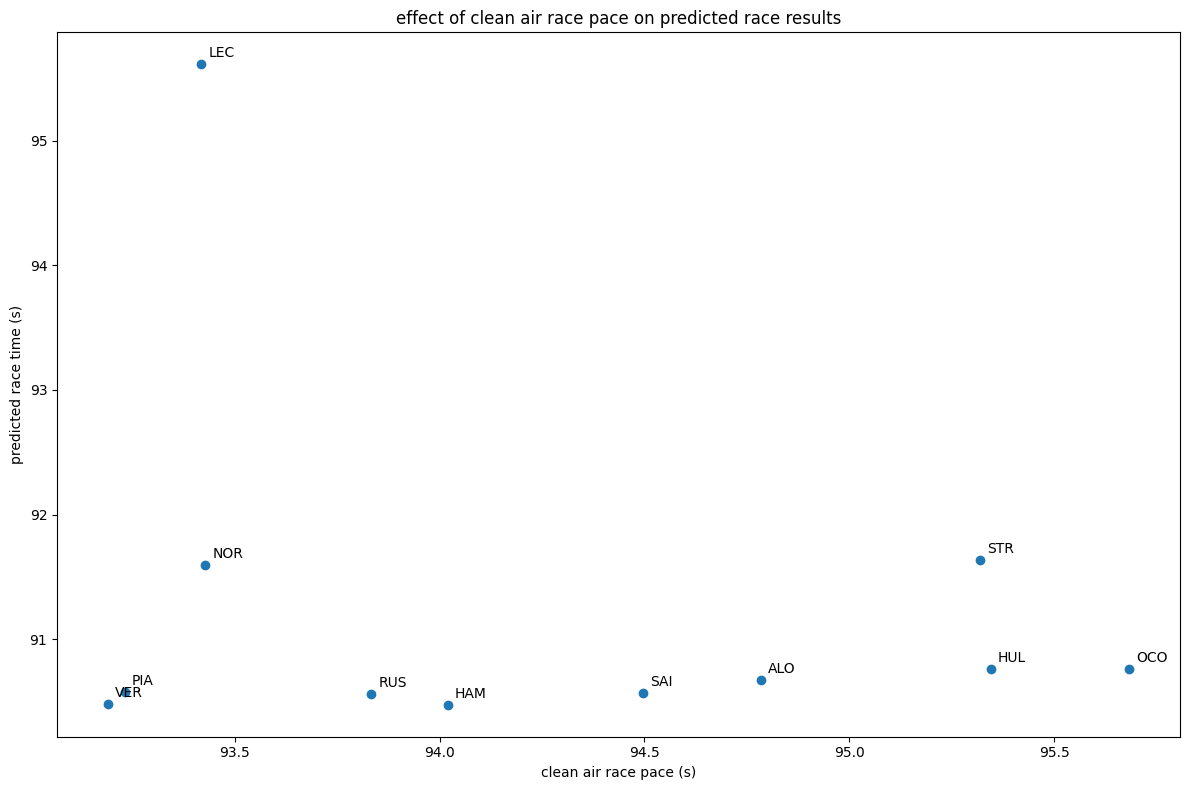

In [18]:
# plot effect of clean air race pace
plt.figure(figsize=(12, 8))
plt.scatter(final_results["CleanAirRacePace (s)"], final_results["PredictedRaceTime (s)"])
for i, driver in enumerate(final_results["Driver"]):
    plt.annotate(driver, (final_results["CleanAirRacePace (s)"].iloc[i], final_results["PredictedRaceTime (s)"].iloc[i]),
                 xytext=(5, 5), textcoords='offset points')
plt.xlabel("clean air race pace (s)")
plt.ylabel("predicted race time (s)")
plt.title("effect of clean air race pace on predicted race results")
plt.tight_layout()
plt.show()

In [19]:
final_results = merged_data.sort_values("PredictedRaceTime (s)").reset_index(drop=True)
podium = final_results.loc[:2, ["Driver", "PredictedRaceTime (s)"]]

print("\n🏆 Predicted in the Top 3 🏆")
print(f"🥇 P1: {podium.iloc[0]['Driver']}")
print(f"🥈 P2: {podium.iloc[1]['Driver']}")
print(f"🥉 P3: {podium.iloc[2]['Driver']}")


🏆 Predicted in the Top 3 🏆
🥇 P1: HAM
🥈 P2: VER
🥉 P3: RUS
